In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

from modules import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def load_mnist_dataset(dataset, path):

    # Scan all the directories and create a list of labels
    labels = os.listdir(os.path.join(path, dataset))

    # Create lists for samples and labels
    X = []
    y = []


    # For each label folder
    for label in labels:
        # And for each image in given folder
        for file in os.listdir(os.path.join(path, dataset, label)):
            # Read the image
            image = cv2.imread(
                        os.path.join(path, dataset, label, file),
                        cv2.IMREAD_UNCHANGED)

            # And append it and a label to the lists
            X.append(image)
            y.append(label)

    # Convert the data to proper numpy arrays and return
    return np.array(X), np.array(y).astype('uint8')


# MNIST dataset (train + test)
def create_data_mnist(path):

    # Load both sets separately
    X, y = load_mnist_dataset('train', path)
    X_test, y_test = load_mnist_dataset('test', path)

    # And return all the data
    return X, y, X_test, y_test


# Create dataset
X, y, X_test, y_test = create_data_mnist('fashion_mnist_images')

# Shuffle the training dataset
keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)
X = X[keys]
y = y[keys]

# Scale and reshape samples
X = (X.reshape(X.shape[0], -1).astype(np.float32) - 127.5) / 127.5
X_test = (X_test.reshape(X_test.shape[0], -1).astype(np.float32) -
             127.5) / 127.5

In [3]:
class MLP(Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.model = Sequential(
            Linear(in_features, hidden_size),
            BatchNormalization(),
            ReLU(),
            Linear(hidden_size, hidden_size),
            ReLU(),
            Linear(hidden_size, num_classes),
            LogSoftMax(),
        )
    
    
    def forward(self, x):
        return self.model(x)

In [4]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 128
NUM_EPOCHS = 10

BATCH_SIZE = 128

criterian = ClassNLLCriterion()

mlp = MLP(IMG_SIZE**2, NUM_CLASSES, HIDDEN_SIZE)

In [5]:
def plot_metrics(train_accuracies, train_losses, val_accuracies, val_losses, epochs):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(model, X, y, *, epochs=1, batch_size=None, print_every=1, validation_data=None, config=None):
    # Initialize state object for storing previous gradients
    state = {}
    
    # Lists to store training and validation metrics
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    # Main training loop for epochs
    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}/{epochs}:')

        # Shuffle data at the beginning of each epoch
        if batch_size is not None:
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

        # Calculate the number of training steps
        train_steps = len(X) // batch_size if batch_size else 1
        if batch_size and len(X) % batch_size != 0:
            train_steps += 1

        # Initialize metrics for this epoch
        epoch_train_loss = 0
        epoch_train_accuracy = 0

        # Progress bar for training steps
        with tqdm(total=train_steps, desc=f"Training", unit="step") as pbar:
            for step in range(train_steps):
                model.train()
                # Prepare the mini-batch
                if batch_size is None:
                    batch_X = X
                    batch_y = y
                else:
                    batch_X = X[step * batch_size:(step + 1) * batch_size]
                    batch_y = y[step * batch_size:(step + 1) * batch_size]

                # Forward pass
                output = model.model.forward(batch_X)
                loss = criterian.forward(output, batch_y)
                
                # Backward pass
                grad_output = criterian.backward(output, batch_y)
                grad_input = model.model.backward(batch_X, grad_output)
                
                # Update the parameters
                sgd_momentum(model.model.getParameters(), model.model.getGradParameters(), config, state)

                # Update metrics
                predictions = np.argmax(output, axis=1)
                accuracy = np.mean(predictions == batch_y)
                epoch_train_loss += loss
                epoch_train_accuracy += accuracy
                
                if not step % print_every or step == train_steps - 1:
                    pbar.set_postfix(accuracy=f'{accuracy:.3f}', loss=f'{loss:.3f}')

                pbar.update(1)

        # Average metrics for this epoch
        avg_train_loss = epoch_train_loss / train_steps
        avg_train_accuracy = epoch_train_accuracy / train_steps
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validation at the end of each epoch, if validation data is provided
        if validation_data is not None:
            model.evaluate()
            X_val, y_val = validation_data
            val_output = model.model.forward(X_val)
            val_loss = criterian.forward(val_output, y_val)
            val_predictions = np.argmax(val_output, axis=1)
            val_accuracy = np.mean(val_predictions == y_val)

            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print(f'Validation - Accuracy: {val_accuracy:.3f}, Loss: {val_loss:.3f}')

        print('-' * 50)

    plot_metrics(train_accuracies, train_losses, val_accuracies, val_losses, epochs)

Epoch 1/20:


Training: 100%|██████████| 469/469 [00:04<00:00, 95.86step/s, accuracy=0.844, loss=0.393] 


Validation - Accuracy: 0.850, Loss: 0.417
--------------------------------------------------
Epoch 2/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 120.82step/s, accuracy=0.802, loss=0.541]


Validation - Accuracy: 0.865, Loss: 0.375
--------------------------------------------------
Epoch 3/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 120.79step/s, accuracy=0.844, loss=0.476]


Validation - Accuracy: 0.870, Loss: 0.354
--------------------------------------------------
Epoch 4/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 124.77step/s, accuracy=0.875, loss=0.399]


Validation - Accuracy: 0.872, Loss: 0.344
--------------------------------------------------
Epoch 5/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 121.19step/s, accuracy=0.906, loss=0.276]


Validation - Accuracy: 0.874, Loss: 0.351
--------------------------------------------------
Epoch 6/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 120.59step/s, accuracy=0.938, loss=0.205]


Validation - Accuracy: 0.878, Loss: 0.337
--------------------------------------------------
Epoch 7/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 121.21step/s, accuracy=0.875, loss=0.293]


Validation - Accuracy: 0.880, Loss: 0.333
--------------------------------------------------
Epoch 8/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 123.99step/s, accuracy=0.917, loss=0.252]


Validation - Accuracy: 0.880, Loss: 0.328
--------------------------------------------------
Epoch 9/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 119.37step/s, accuracy=0.906, loss=0.251]


Validation - Accuracy: 0.875, Loss: 0.341
--------------------------------------------------
Epoch 10/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 130.58step/s, accuracy=0.823, loss=0.472]


Validation - Accuracy: 0.884, Loss: 0.326
--------------------------------------------------
Epoch 11/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 124.01step/s, accuracy=0.979, loss=0.101]


Validation - Accuracy: 0.883, Loss: 0.325
--------------------------------------------------
Epoch 12/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 119.06step/s, accuracy=0.958, loss=0.121]


Validation - Accuracy: 0.887, Loss: 0.327
--------------------------------------------------
Epoch 13/20:


Training: 100%|██████████| 469/469 [00:04<00:00, 115.25step/s, accuracy=0.958, loss=0.142]


Validation - Accuracy: 0.891, Loss: 0.319
--------------------------------------------------
Epoch 14/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 126.09step/s, accuracy=0.917, loss=0.255]


Validation - Accuracy: 0.891, Loss: 0.323
--------------------------------------------------
Epoch 15/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 125.69step/s, accuracy=0.938, loss=0.196]


Validation - Accuracy: 0.889, Loss: 0.320
--------------------------------------------------
Epoch 16/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 123.45step/s, accuracy=0.906, loss=0.178]


Validation - Accuracy: 0.891, Loss: 0.320
--------------------------------------------------
Epoch 17/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 121.91step/s, accuracy=0.917, loss=0.147]


Validation - Accuracy: 0.889, Loss: 0.340
--------------------------------------------------
Epoch 18/20:


Training: 100%|██████████| 469/469 [00:04<00:00, 115.20step/s, accuracy=0.917, loss=0.153]


Validation - Accuracy: 0.882, Loss: 0.353
--------------------------------------------------
Epoch 19/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 123.05step/s, accuracy=0.958, loss=0.121]


Validation - Accuracy: 0.879, Loss: 0.366
--------------------------------------------------
Epoch 20/20:


Training: 100%|██████████| 469/469 [00:03<00:00, 123.82step/s, accuracy=0.958, loss=0.114]


Validation - Accuracy: 0.889, Loss: 0.334
--------------------------------------------------


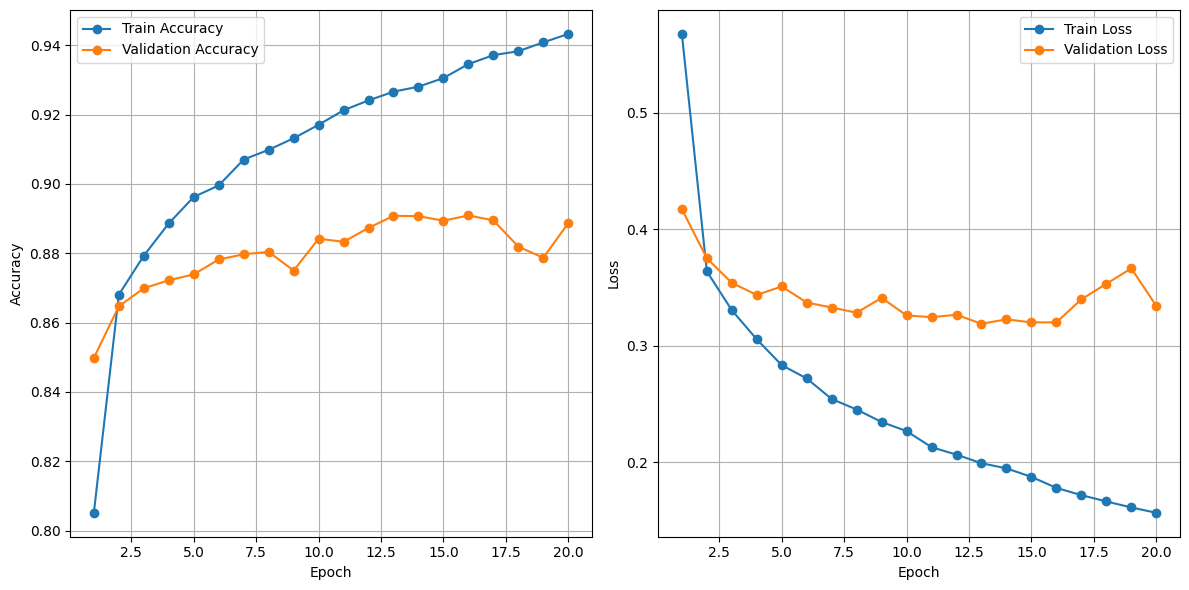

In [7]:
config = {
    'learning_rate': 0.01,
    'momentum': 0.9
}


train(mlp, X, y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, print_every=100, validation_data=(X_test, y_test), config=config)